In [1]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import catboost
from catboost import CatBoostRanker, Pool
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go

In [2]:
# Загрузка данных
payments_1 = pd.read_csv('data/payments_1.csv').sort_values("eventTimeRes")#[:50000]
payments_1['eventTimeRes'] = pd.to_datetime(payments_1['eventTimeRes'])

providers_1 = pd.read_csv('data/providers_1.csv')
providers_1['COMMISSION'] = pd.to_numeric(providers_1['COMMISSION'], errors='coerce')
providers_1['LIMIT_BY_CARD'] = pd.to_numeric(providers_1['LIMIT_BY_CARD'], errors='coerce')



providers_1['BUSY_UNTIL'] = pd.Timestamp.min
providers_1['DAILY_TOTAL'] = 0.0  # Сумма обработанных платежей в текущий день
providers_1['LAST_DATE'] = pd.Timestamp.min  # Последний день обработки платежей

# Преобразуем колонки с временными метками в datetime
providers_1['TIME'] = pd.to_datetime(providers_1['TIME'])


In [3]:
payments_2 = pd.read_csv('data/payments_2.csv').sort_values("eventTimeRes")
payments_2['eventTimeRes'] = pd.to_datetime(payments_2['eventTimeRes'])

providers_2 = pd.read_csv('data/providers_2.csv')
providers_2['COMMISSION'] = pd.to_numeric(providers_2['COMMISSION'], errors='coerce')
providers_2['LIMIT_BY_CARD'] = pd.to_numeric(providers_2['LIMIT_BY_CARD'], errors='coerce')


providers_2['BUSY_UNTIL'] = pd.Timestamp.min
providers_2['DAILY_TOTAL'] = 0.0  # Сумма обработанных платежей в текущий день
providers_2['LAST_DATE'] = pd.Timestamp.min  # Последний день обработки платежей

# Преобразуем колонки с временными метками в datetime
providers_2['TIME'] = pd.to_datetime(providers_2['TIME'])

In [4]:
def reset_daily_totals(providers_df, payment_date):
    """Сбрасывает лимиты провайдеров в начале нового дня."""
    providers_df.loc[providers_df['LAST_DATE'] < payment_date, ['DAILY_TOTAL', 'LAST_DATE']] = [0.0, payment_date]

In [5]:
providers_1.drop("LIMIT_BY_CARD", axis=1, inplace=True)
providers_2.drop("LIMIT_BY_CARD", axis=1, inplace=True)

In [6]:
%%time

def get_valid_providers_with_profits(payment_time, payment_amount, payment_currency, providers_df):
    """Возвращает список доступных провайдеров с расчетом прибыли, отсортированный по убыванию profit."""
    # Сбрасываем ежедневные лимиты, если начался новый день
    reset_daily_totals(providers_df, payment_time.normalize())
    
    # Отбираем провайдеров, чье время актуальности <= времени платежа
    valid_providers = providers_df[providers_df['TIME'] <= payment_time]

    # Оставляем только записи с той же датой, что и транзакция
    valid_providers = valid_providers[valid_providers['TIME'].dt.date == payment_time.date()]

    # Для каждого провайдера оставляем только последнюю запись (по времени) после фильтрации
    valid_providers = valid_providers.loc[valid_providers.groupby('ID')['TIME'].idxmax()]
    
    # Фильтрация по валюте
    valid_providers = valid_providers[valid_providers['CURRENCY'] == payment_currency]

    if valid_providers.empty:
        return ['NO CURRENCY']
    
    # Исключаем провайдеров, которые заняты на момент платежа
    # valid_providers = valid_providers[valid_providers['BUSY_UNTIL'] <= payment_time]
    
    # Исключаем провайдеров, которые превышают максимальный дневной лимит
    valid_providers = valid_providers[valid_providers['DAILY_TOTAL'] + payment_amount <= valid_providers['LIMIT_MAX']]

        # Дополнительная фильтрация по сумме платежа (минимум и максимум)
    valid_providers = valid_providers[(valid_providers['MIN_SUM'] <= payment_amount) & 
                                      (valid_providers['MAX_SUM'] >= payment_amount)]
    
    if valid_providers.empty:
        return ["GOING BEYOND MIN_MAX"]  # Если нет подходящих провайдеров, возвращаем пустой список
    
    # Рассчитываем profit для каждого провайдера
    valid_providers = valid_providers.copy()  # Создаем копию для модификации
    valid_providers['PROFIT'] = payment_amount - (payment_amount * valid_providers['COMMISSION'])
    
    # Сортируем провайдеров по убыванию прибыли
    valid_providers = valid_providers.sort_values(by='PROFIT', ascending=False)
        
    # Обновляем DAILY_TOTAL, BUSY_UNTIL и LAST_DATE для выбранных провайдеров
    for provider_id in valid_providers['ID']:
        providers_df.loc[providers_df['ID'] == provider_id, 'DAILY_TOTAL'] += payment_amount
        providers_df.loc[providers_df['ID'] == provider_id, 'BUSY_UNTIL'] = payment_time + pd.to_timedelta(valid_providers.loc[valid_providers['ID'] == provider_id, 'AVG_TIME'].values[0], unit='s')
        providers_df.loc[providers_df['ID'] == provider_id, 'LAST_DATE'] = payment_time.normalize()
    # Преобразуем в список словарей
    return valid_providers.to_dict('records')

def get_providers_with_profit_list(row, providers_df):
    """Возвращает список провайдеров с расчетом прибыли для конкретного платежа."""
    # Получаем список подходящих провайдеров с их прибыльностью
    valid_providers_with_profits = get_valid_providers_with_profits(
        row['eventTimeRes'], row['amount'], row['cur'], providers_df
    )
    
    if not valid_providers_with_profits:
        return pd.Series({
            'payment': row['payment'],
            'valid_providers': None,  # Список подходящих провайдеров пуст
        })
    
    return pd.Series({
        'payment': row['payment'],
        'valid_providers': valid_providers_with_profits,  # Список подходящих провайдеров с расчетом прибыли
    })

# Применяем функцию к каждому платежу
payments_with_providers_df = payments_1.drop('cardToken', axis=1)\
                                        .apply(lambda row: get_providers_with_profit_list(row, providers_1), axis=1)

# Объединяем исходные данные с рассчитанными
# final_df = pd.concat([payments_1, payments_with_providers_df], axis=1)


CPU times: user 20min 22s, sys: 2.21 s, total: 20min 24s
Wall time: 20min 24s


In [7]:
%%time
payments_with_providers_df_2 = payments_2.drop('cardToken', axis=1)\
                                        .apply(lambda row: get_providers_with_profit_list(row, providers_2), axis=1)

CPU times: user 20min 5s, sys: 2.23 s, total: 20min 7s
Wall time: 20min 7s


In [16]:
payments_with_providers_df.head(2)

,payment,valid_providers
193977,c77be33e8db2f5352ebbc0a1b3f10e3e,"[{'TIME': 2024-11-24 21:00:00, 'ID': 2, 'CONVE..."
193972,c9a03cbbe592f930d52416b049bc1d1a,"[{'TIME': 2024-11-24 21:00:00, 'ID': 2, 'CONVE..."


In [8]:
payments_with_providers_df.shape

(193978, 2)

In [9]:
# Разворачиваем valid_providers с помощью explode
exploded_df = payments_with_providers_df.explode('valid_providers', ignore_index=True)

# Разворачиваем dict в отдельные колонки
providers_expanded = pd.json_normalize(exploded_df['valid_providers'])
final_exploded_df = pd.concat([exploded_df.drop(columns=['valid_providers']), providers_expanded], axis=1)

final_exploded_df = final_exploded_df[~final_exploded_df['PROFIT'].isna()]

final_exploded_df['rank']=final_exploded_df.groupby('payment')['PROFIT']\
    .rank(ascending=False, method='first')\
    .astype(int)

final_exploded_df.head(2)

,payment,TIME,ID,CONVERSION,AVG_TIME,MIN_SUM,MAX_SUM,LIMIT_MIN,LIMIT_MAX,COMMISSION,CURRENCY,BUSY_UNTIL,DAILY_TOTAL,LAST_DATE,PROFIT,rank
0,c77be33e8db2f5352ebbc0a1b3f10e3e,2024-11-24 21:00:00,2.0,0.5,18.0,400.0,8500.0,51000.0,13400000.0,0.03,RUB,1677-09-21 00:12:43.145224193,0.0,2024-11-24,679.0,1
1,c77be33e8db2f5352ebbc0a1b3f10e3e,2024-11-24 21:00:00,5.0,0.6,14.0,600.0,4500.0,31000.0,28000000.0,0.03,RUB,1677-09-21 00:12:43.145224193,0.0,2024-11-24,679.0,2


In [10]:
final_exploded_df.shape

(104330, 16)

In [11]:
# Разворачиваем valid_providers с помощью explode
exploded_df_2 = payments_with_providers_df_2.explode('valid_providers', ignore_index=True)

# Разворачиваем dict в отдельные колонки
providers_expanded_2 = pd.json_normalize(exploded_df_2['valid_providers'])
final_exploded_df_2 = pd.concat([exploded_df_2.drop(columns=['valid_providers']), providers_expanded_2], axis=1)

final_exploded_df_2 = final_exploded_df_2[~final_exploded_df_2['PROFIT'].isna()]

final_exploded_df_2['rank']=final_exploded_df_2.groupby('payment')['PROFIT']\
    .rank(ascending=False, method='first')\
    .astype(int)

final_exploded_df_2.head(2)

,payment,TIME,ID,CONVERSION,AVG_TIME,MIN_SUM,MAX_SUM,LIMIT_MIN,LIMIT_MAX,COMMISSION,CURRENCY,BUSY_UNTIL,DAILY_TOTAL,LAST_DATE,PROFIT,rank
0,a12fb751e8dfe10f6d28449ba56bb7a1,2024-11-25 21:00:00,10.0,0.75,18.0,100.0,4500.0,81000.0,30700000.0,0.050,BRL,1677-09-21 00:12:43.145224193,0.0,2024-11-25,213.75,1
7,5833a5a2110db3d0ce72f847d5babeb5,2024-11-25 21:00:00,0.0,0.70,14.0,800.0,7000.0,91000.0,24700000.0,0.035,RUB,1677-09-21 00:12:43.145224193,0.0,2024-11-25,3377.50,1


In [12]:
final_exploded_df_2.shape

(110048, 16)

In [13]:
cols = ['payment','CONVERSION', 'AVG_TIME', 'MIN_SUM', 'MAX_SUM',
       'LIMIT_MIN', 'LIMIT_MAX', 'COMMISSION', 'CURRENCY', 'ID',
     'DAILY_TOTAL', 'LAST_DATE', 'PROFIT']

In [14]:
# label_encoder = LabelEncoder()
# final_exploded_df['currency_encoded'] = label_encoder.fit_transform(final_exploded_df['CURRENCY'])
final_exploded_df.reset_index(drop=True, inplace=True)
final_exploded_df_2.reset_index(drop=True, inplace=True)

In [15]:
# Создадим массив с количеством провайдеров для каждого платежа
group_sizes = final_exploded_df.groupby('payment').size().reset_index()
group_sizes.columns = ['payment', 'group']

group_sizes_2 = final_exploded_df_2.groupby('payment').size().reset_index()
group_sizes_2.columns = ['payment', 'group']

grouped = final_exploded_df.merge(group_sizes, on='payment', how='left').sort_values("group")

grouped_2 = final_exploded_df_2.merge(group_sizes_2, on='payment', how='left').sort_values("group")

In [16]:
X_train = grouped[cols]
y_train = grouped['rank']
group_train = grouped['group']

X_test = grouped_2[cols]
y_test = grouped_2['rank']
group_test = grouped_2['group']

In [18]:
# Создаем и обучаем модель CatBoostRanker
ranker = CatBoostRanker(
    iterations=1000, 
    learning_rate=0.1,
    depth=6,
    loss_function='RMSE',  # Для ранжирования лучше использовать RMSE или другие метрики
    # cat_features=['currency_encoded'],  # Указываем категориальные признаки
    random_seed=42,
    verbose=100
)

In [19]:
train_pool = Pool(X_train.drop(['payment', 'ID'], axis=1), y_train, group_id=group_train, cat_features=['CURRENCY'])
test_pool = Pool(X_test.drop(['payment', 'ID'], axis=1), y_test, group_id=group_test, cat_features=['CURRENCY'])

In [20]:
ranker.fit(train_pool, eval_set=test_pool, early_stopping_rounds=100, verbose=100)

/home/dm/anaconda3/lib/python3.8/site-packages/catboost/core.py:6245: RuntimeWarning: Regression loss ('RMSE') ignores an important ranking parameter 'group_id'
  warnings.warn("Regression loss ('{}') ignores an important ranking parameter 'group_id'".format(loss_function), RuntimeWarning)


0:	learn: 0.8440397	test: 0.7744563	best: 0.7744563 (0)	total: 88.2ms	remaining: 1m 28s
100:	learn: 0.1738482	test: 0.7350950	best: 0.7210345 (15)	total: 1.54s	remaining: 13.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7210344608
bestIteration = 15

Shrink model to first 16 iterations.


In [21]:
# Предсказания на тестовом наборе
y_pred = ranker.predict(test_pool)


mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.5198906936429922


In [22]:
final_exploded_df_test = X_test.copy()
final_exploded_df_test['predicted_rank'] = y_pred

# Сортируем по предсказанному рангу и группируем по платежам
ranked_providers_df = final_exploded_df_test.sort_values(by=['payment', 'predicted_rank'], ascending=[True, True])
ranked_providers_df['ID'] = ranked_providers_df['ID'].astype(int)

test_flow = ranked_providers_df.groupby('payment', as_index=False).agg({
    'ID': lambda ids: '-'.join(map(str, sorted(ids)))})

test_flow.columns = ['payment', 'flow']

In [23]:
final_exploded_df_train = X_train.copy()
final_exploded_df_train['predicted_rank'] = ranker.predict(train_pool)

# Сортируем по предсказанному рангу и группируем по платежам
ranked_providers_df_train = final_exploded_df_train.sort_values(by=['payment', 'predicted_rank'], ascending=[True, True])
ranked_providers_df_train['ID'] = ranked_providers_df_train['ID'].astype(int)

train_flow = ranked_providers_df_train.groupby('payment', as_index=False).agg({
    'ID': lambda ids: '-'.join(map(str, sorted(ids)))})

train_flow.columns = ['payment', 'flow']

In [36]:
train_flow

,payment,flow
0,00009bdf8a13313b2b94e51b3d6a4239,2-4-5
1,000533c5ce9b6061632e2c4773c84511,2-3-4-5
2,00054205027674566734f253b203a0ac,2-4-5
3,000560e8e56d6c116110ee8202995e20,1
4,0005bc773b322e44dc52791d774d57b4,2-3-4
...,...,...
50840,fff9255ff8963be624e036c5f6bac8d2,16
50841,fff9a53b596055c0ad1694c454874548,13
50842,fff9aa209a323f999d03ebd049800dfc,14-16
50843,fffc3ee7138b64e501526fccb91033f2,4


In [37]:
payments_with_providers_df

,payment,valid_providers
193977,c77be33e8db2f5352ebbc0a1b3f10e3e,"[{'TIME': 2024-11-24 21:00:00, 'ID': 2, 'CONVE..."
193972,c9a03cbbe592f930d52416b049bc1d1a,"[{'TIME': 2024-11-24 21:00:00, 'ID': 2, 'CONVE..."
193973,f3adde51de36a39508d11d4bf4a98edc,[GOING BEYOND MIN_MAX]
193976,0ab79b6d41d6e887e84ec4a85ea33733,[GOING BEYOND MIN_MAX]
193975,90a88e0d5b6bfff12909878f265cc2f4,[GOING BEYOND MIN_MAX]
...,...,...
4,4af690ba4eebb6d4782d9a3051dc58d2,[GOING BEYOND MIN_MAX]
3,c30b3850e85454145bcb0dda3d209d88,[GOING BEYOND MIN_MAX]
2,0e2705d1083b67f2c5ea12de3b7ab182,[GOING BEYOND MIN_MAX]
1,6eb49e22afdd28083ff82cdff8068880,[GOING BEYOND MIN_MAX]


In [46]:
p1 = pd.concat([payments_1, payments_with_providers_df.drop('payment', axis=1)], axis=1).merge(train_flow, on='payment', how='left')
p2 = pd.concat([payments_2, payments_with_providers_df_2.drop('payment', axis=1)], axis=1).merge(test_flow, on='payment', how='left')

p1['flow'] = p1['flow'].fillna(value='False')
p2['flow'] = p2['flow'].fillna(value='False')

In [52]:
pd.to_pickle(ranker, "ranker.pkl")
p1.to_csv("p1.csv", index=False)
p2.to_csv("p2.csv", index=False)

In [29]:
cols2 = [
 'CONVERSION',
 'AVG_TIME',
 'MIN_SUM',
 'MAX_SUM',
 'LIMIT_MIN',
 'LIMIT_MAX',
 'COMMISSION',
 'CURRENCY',
 'DAILY_TOTAL',
 'LAST_DATE',
 'PROFIT']

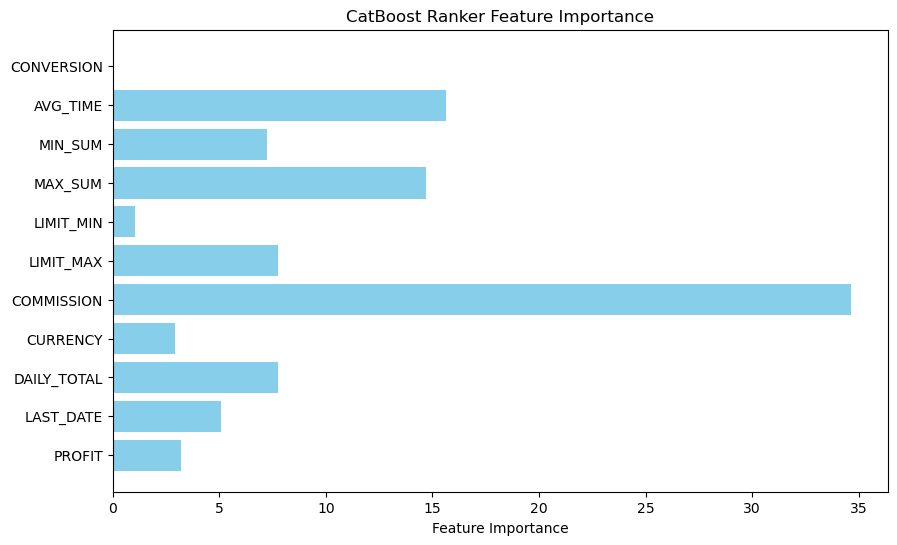

In [30]:
# Получаем важность признаков
feature_importance = ranker.get_feature_importance(train_pool, type='PredictionValuesChange')

# Визуализация важности
plt.figure(figsize=(10, 6))
plt.barh(cols2, feature_importance, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('CatBoost Ranker Feature Importance')
plt.gca().invert_yaxis()
plt.show()

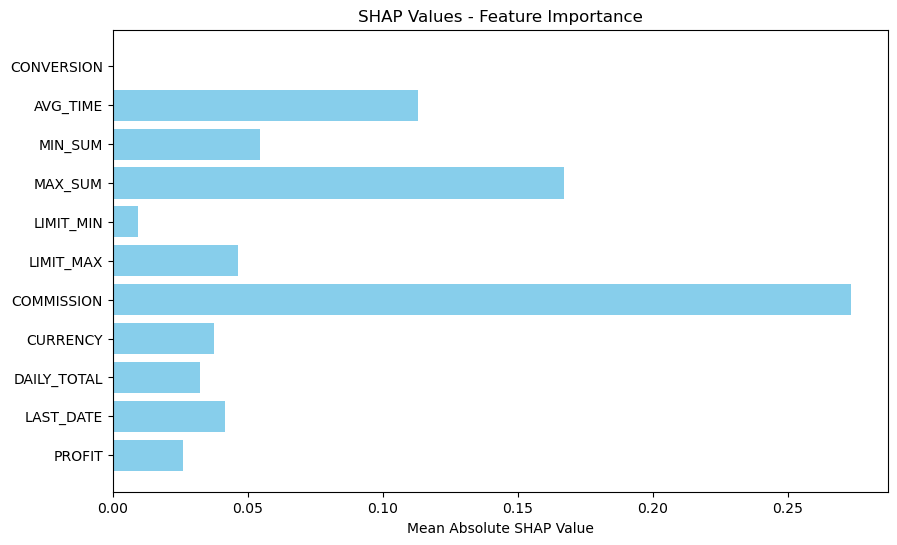

In [35]:
# Получаем SHAP значения
shap_values = ranker.get_feature_importance(train_pool, type='ShapValues')

# SHAP возвращает матрицу [n_samples, n_features + 1], последний столбец - базовое значение
shap_values = np.array(shap_values)[ :, :-1]  # Убираем базовые значения

# Визуализация общего вклада признаков
mean_shap = np.abs(shap_values).mean(axis=0)
plt.figure(figsize=(10, 6))
plt.barh(cols2, mean_shap, color='skyblue')
plt.xlabel('Mean Absolute SHAP Value')
plt.title('SHAP Values - Feature Importance')
plt.gca().invert_yaxis()
plt.show()

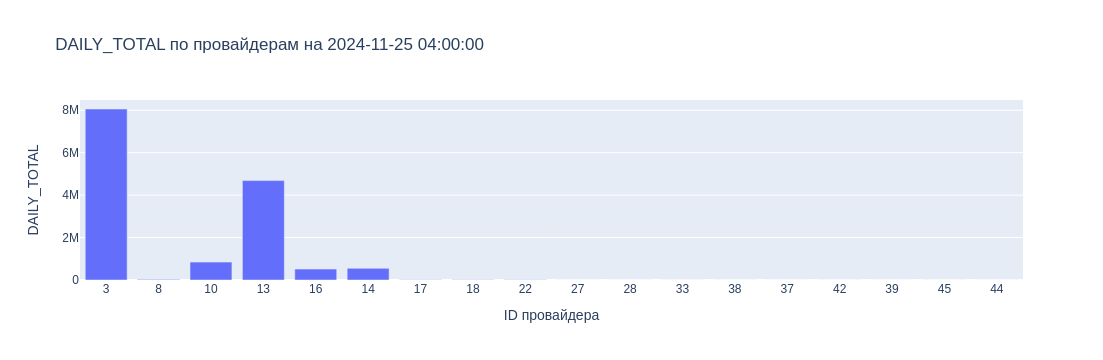

In [43]:
# Указанный момент времени
selected_time = pd.to_datetime('2024-11-25 04:00:00')

# Отфильтровываем данные по выбранному времени
df_filtered = df[df['TIME'] == selected_time]

# Создаем график
fig = go.Figure()

# Добавляем столбцы на график для выбранного времени
fig.add_trace(go.Bar(
    x=df_filtered['ID'],  # ID провайдеров по оси X
    y=df_filtered['DAILY_TOTAL'],  # Значения DAILY_TOTAL по оси Y
))

# Обновляем настройки графика
fig.update_layout(
    title=f"DAILY_TOTAL по провайдерам на {selected_time}",
    xaxis=dict(
        title='ID провайдера',
        type='category',  # Чтобы ID провайдеров отображались как категории
    ),
    yaxis=dict(
        title='DAILY_TOTAL',
    ),
    barmode='group'  # Можно использовать для нескольких групп столбцов
)

# Отображаем график
fig.show()

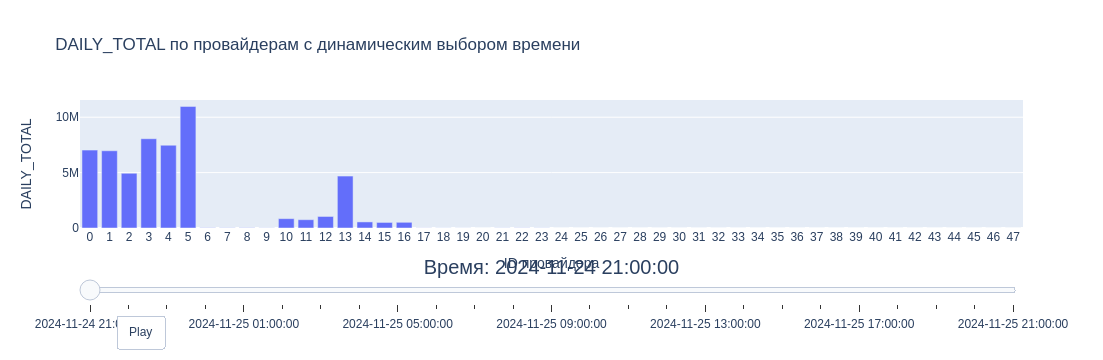

In [51]:
# Уникальные временные метки, отсортированные по возрастанию
time_values = sorted(df['TIME'].unique())

# Создаем фигуру
fig = go.Figure()

# Добавляем фреймы для анимации (для каждой временной метки)
frames = [
    go.Frame(
        data=[go.Bar(
            x=df[df['TIME'] == time]['ID'],  # ID провайдеров по оси X
            y=df[df['TIME'] == time]['DAILY_TOTAL'],  # Значения DAILY_TOTAL по оси Y
            name=str(time),  # Название для временной метки
        )],
        name=str(time)  # Название фрейма для времени
    ) 
    for time in time_values
]

# Добавляем первый фрейм для инициализации
fig.add_trace(go.Bar(
    x=df[df['TIME'] == time_values[0]]['ID'], 
    y=df[df['TIME'] == time_values[0]]['DAILY_TOTAL'],
))

# Шаги слайдера для управления анимацией
steps = [
    {
        'args': [
            [str(time)],  # Показывать данные для выбранного времени
            {
                'frame': {'duration': 300, 'redraw': True},  # Задержка на 300 мс
                'mode': 'immediate',
                'transition': {'duration': 300, 'easing': 'cubic-in-out'}
            }
        ],
        'label': str(time),  # Метка с временной меткой
        'method': 'animate'  # Метод анимации
    }
    for time in time_values
]

# Настройка слайдера
sliders = [
    {
        'active': 0,  # Начальный шаг слайдера
        'currentvalue': {
            'font': {'size': 20},
            'prefix': 'Время: ',
            'visible': True,
            'xanchor': 'center',
        },
        'pad': {'b': 10},
        'steps': steps,
    }
]

# Обновляем макет графика
fig.update_layout(
    title="DAILY_TOTAL по провайдерам с динамическим выбором времени",
    xaxis=dict(
        title='ID провайдера',
        type='category',  # Чтобы ID провайдеров отображались как категории
    ),
    yaxis=dict(
        title='DAILY_TOTAL',
    ),
    sliders=sliders,
    updatemenus=[{
        'buttons': [{
            'args': [None, {'frame': {'duration': 500, 'redraw': False}, 'mode': 'immediate', 'transition': {'duration': 0}}],
            'label': 'Play',
            'method': 'animate'
        }],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': False,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }],
    showlegend=False
)

# Добавляем фреймы
fig.frames = frames  # Интегрируем фреймы в график

# Отображаем график
fig.show()

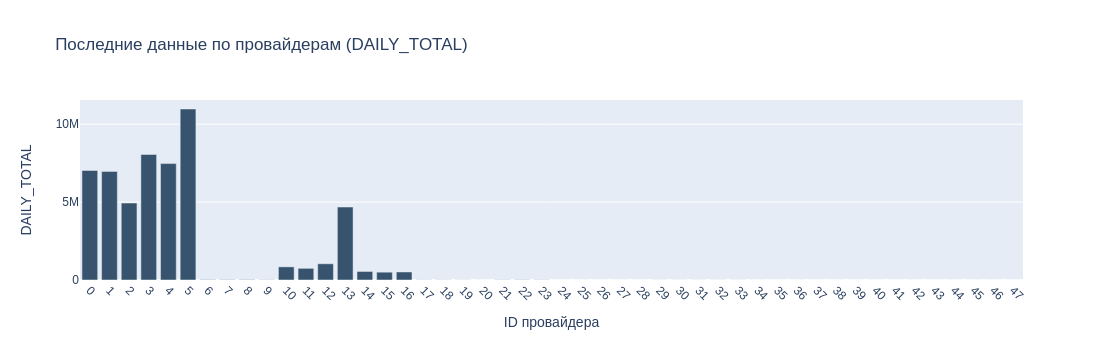

In [53]:
# Преобразуем столбец TIME в datetime, если это еще не сделано
df['TIME'] = pd.to_datetime(df['TIME'])

# Для каждого ID выбираем последнюю запись по времени
latest_records_df = df.loc[df.groupby('ID')['TIME'].idxmax()]

# Создаем график
fig = go.Figure()

# Добавляем столбцы (бар) на график
fig.add_trace(go.Bar(
    x=latest_records_df['ID'],  # ID провайдеров по оси X
    y=latest_records_df['DAILY_TOTAL'],  # Значения DAILY_TOTAL по оси Y
    marker=dict(color='rgb(55, 83, 109)'),
))

# Настройка графика
fig.update_layout(
    title="Последние данные по провайдерам (DAILY_TOTAL)",
    xaxis=dict(
        title='ID провайдера',
        type='category',  # Показываем ID как категории
        tickangle=45  # Угол наклона меток на оси X
    ),
    yaxis=dict(
        title='DAILY_TOTAL',
    ),
    showlegend=False
)

# Отображаем график
fig.show()